In [1]:
import logreader as lr
from pathlib import Path
import matplotlib.pyplot as plt
import pickle

In [2]:
#PARAMETERS
session_path = Path('/ceph/imaging1/arie/429420_toms/20230203_429420')
log_file = session_path.joinpath('20230203-122152_329.b64')
tif_file = session_path.joinpath('20230203_429420_00002.tif')


save_data = False

# Decode session log and tif header

In [3]:
decoded_log = lr.create_bp_structure(log_file)

Decoding log file


  0%|          | 0/2903712 [00:00<?, ?it/s]

In [4]:
i2c,frames = lr.read_ScanImageTiffHeader(str(tif_file))

Reading .tif header


  0%|          | 0/86592 [00:00<?, ?it/s]

# Arrange and plot chanel data

In [5]:
for k in decoded_log.keys():
    print(f'{k}: {decoded_log[k].shape}')

analog: (2903712, 8)
digitalIn: (2903712, 16)
digitalOut: (2903712, 8)
startTS: (2903712,)
transmitTS: (2903712,)
longVar: (2903712, 8)
packetNums: (2903712,)


In [6]:
labels_in = ['empty','empty','wheelA','wheelB','wheelC','IR_camera','scanner','sound','unknown','reward_zone','environment1',
             'environment2','environment3_broken','tunnel1','tunnel2','environment3']
labels_out = ['valve','empty','IR_lED_sync','empty','barcode','IR_LED','lick','empty']

In [7]:
digital_in = decoded_log['digitalIn'].astype(int)
digital_out = decoded_log['digitalOut'].astype(int)
digital_scan_signal = digital_in[6]
log_times = decoded_log['startTS']
sync_times = lr.compute_sync_times(digital_scan_signal,log_times,frames)

In [8]:
sync_times

array([  16.67436117,   16.67536117,   16.67636117, ..., 2920.50336117,
       2920.50436117, 2920.50536117])

# Build trial matrix

In [9]:
tm = lr.build_trial_matrix(digital_in,digital_out)

In [10]:
tm

,env_onset,tunnel1_onset,reward_zone_onset,tunnel2_onset,tunnel2_offset,trial_duration,env_label,sound_onset,sound_offset,sound_presented,reward_onset,reward_offset,clean_trial
0,0.0,63402,66526,75805.0,95885.0,95885.0,1.0,52429.0,52429.0,True,68102.0,68102.0,True
1,95885.0,115457,118560,179884.0,187845.0,91960.0,3.0,100524.0,100524.0,True,119267.0,119267.0,True
2,187845.0,225378,228231,303525.0,308711.0,120866.0,3.0,199723.0,199723.0,True,228970.0,228970.0,True
3,308711.0,563807,607098,610652.0,632836.0,324125.0,2.0,NaN,NaN,False,608066.0,608066.0,True
4,632836.0,650912,653486,673626.0,676275.0,43439.0,3.0,641462.0,641462.0,True,654415.0,654415.0,True
5,676275.0,935028,937982,970157.0,971327.0,295052.0,1.0,NaN,NaN,False,938695.0,938695.0,True
6,971327.0,1249698,1359456,1363193.0,1368502.0,397175.0,2.0,NaN,NaN,False,1360201.0,1360201.0,True
7,1368502.0,1396540,1399041,1430221.0,1432231.0,63729.0,2.0,1385766.0,1385766.0,True,1399697.0,1399697.0,True
8,1432231.0,1454231,1457251,1566379.0,1568601.0,136370.0,3.0,1445821.0,1445821.0,True,1458048.0,1458048.0,False
9,1568601.0,1857772,1860180,1872362.0,1879705.0,311104.0,1.0,NaN,NaN,False,1860920.0,1860920.0,True


In [11]:
def compute_position(decoded_log,sync_times):
    position = decoded_log['longVar'][:,1]
    return position
def compute_lick_timestamps(decoded_log,sync_times):
    digital_out = decoded_log['digitalOut'].astype(int)
    lick_idxs = lr.compute_onsets(digital_out[:,-2])
    lick_ts = sync_times[lick_idxs]
    return lick_ts


position = compute_position(decoded_log,sync_times)
licks = compute_lick_timestamps(decoded_log,sync_times)

data = {'time':sync_times,'position':position,'licks':licks}

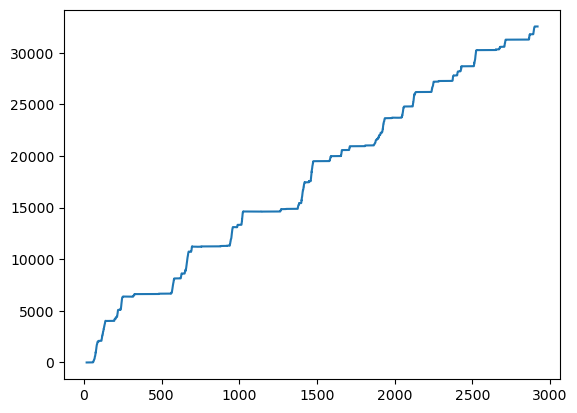

In [12]:
plt.plot(data['time'],data['position'])

In [13]:
#save data
save_path = Path('/scratch/davide/2p_data/429420_toms/20230203_429420')

filename = save_path.joinpath('behaviour.pickle')

with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
tm.to_csv(save_path.joinpath('trial_data.csv'))


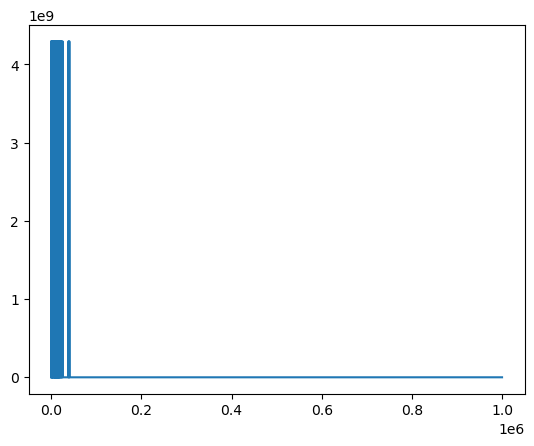

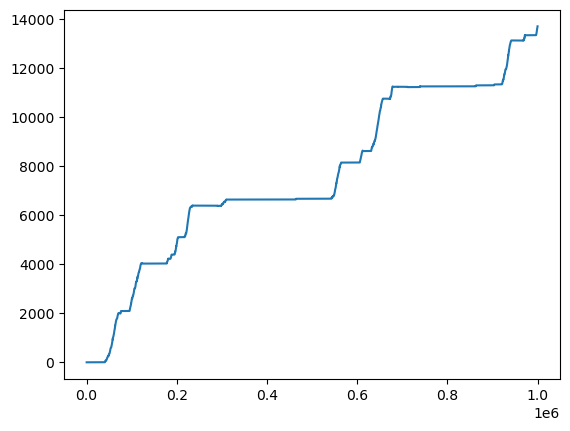

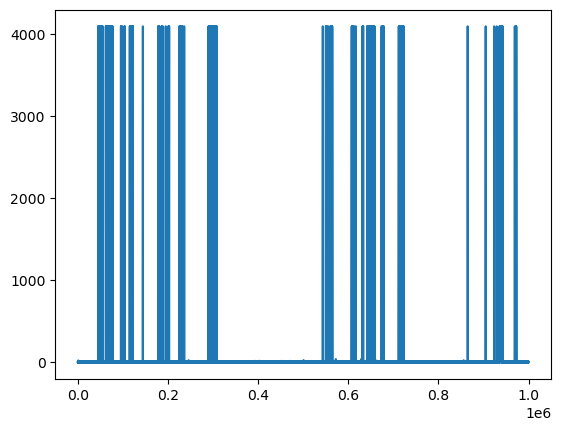

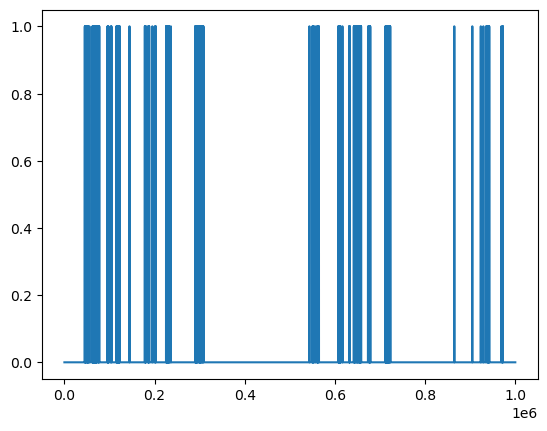

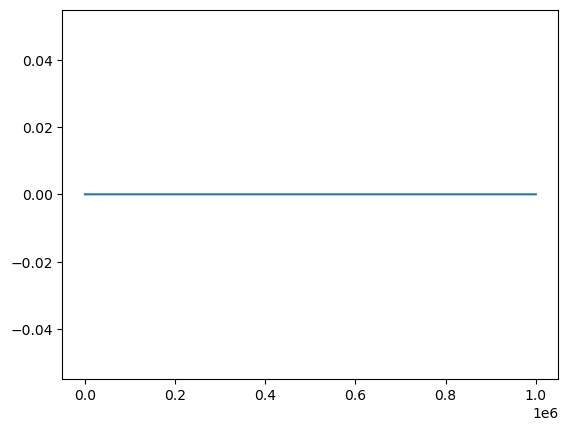

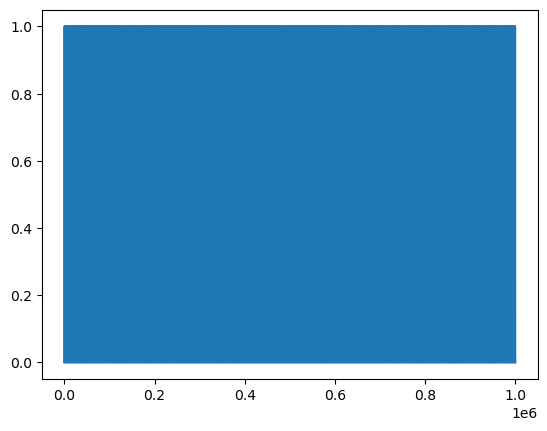

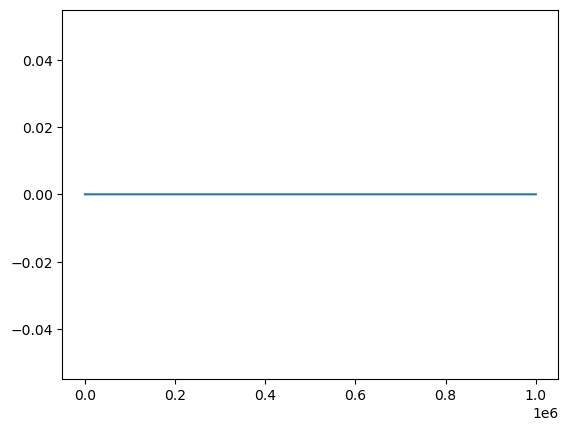

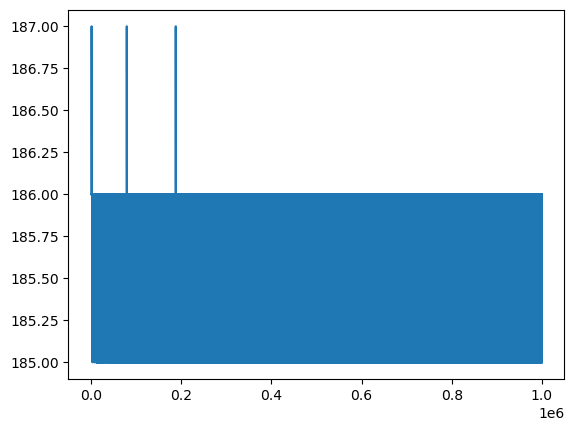

In [22]:
for i in decoded_log['longVar'].T:
    plt.figure()
    plt.plot(i[:1000000])